
# High-Fidelity and Arbitrary Face Editing

Cycle consistency is widely used for face editing. However, we observe that the generator tends to find a tricky way to hide information from the original image to satisfy the constraint of cycle consistency, making it impossible to maintain the rich details (e.g., wrinkles and moles) of non-editing areas. In this work, we propose a simple yet effective method named HifaFace to address the above-mentioned problem from two perspectives. First, we relieve the pres- sure of the generator to synthesize rich details by directly feeding the high-frequency information of the input image into the end of the generator. Second, we adopt an addi- tional discriminator to encourage the generator to synthesize rich details. Specifically, we apply wavelet transformation to transform the image into multi-frequency domains, among which the high-frequency parts can be used to recover the rich details. We also notice that a fine-grained and wider-range control for the attribute is of great impor- tance for face editing. To achieve this goal, we propose a novel attribute regression loss. Powered by the proposed framework, we achieve high-fidelity and arbitrary face edit- ing, outperforming other state-of-the-art approaches.

In [ ]:
%pip install poutyne          # to install the Poutyne library
%pip install wget             # to install the wget library in order to download data
%pip install opencv-python    # to install the cv2 (opencv) library
%pip install pytorch-wavelet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 13.9 MB/s 
     |████████████████████████████████| 419 kB 53.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=271c3b3cd2b85120dc0a2ae9dcef7862749fa92fa86df907f33f07213ef5b382
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1 Imports Modules

In [ ]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import cv2
import wget
import pytorch_wavelet as wavelet
import pywt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as T
import cv2 as cv
import random as random
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.utils import make_grid

## 2 Dataset

The paper evaluates the model on the CelebA-HQ [20] and FFHQ [21] datasets. The classification model trained on CelebA-HQ is applied to get the pseudo labels for all images in FFHQ. The image resolution is chosen as 256 × 256 in our experiments.

In [ ]:
num_epochs = 5
learning_rate = 0.01
batch_size = 16
image_size = 224
w, h = 218, 178  # the width and the hight of original images before resizing
set_seeds(48)
gender_index = 20  # in the CelebA dataset gender information is the 21th item in the attributes vector.
W = 0.4  # the weight of regression loss
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The running processor is...", device)

The running processor is... cpu


In [ ]:
# Downloading the dataset
data_root = "datasets"

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt",
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt",
]

# Path to folder with the dataset
dataset_folder = f"{data_root}/celeba"
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
        wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", "r") as ziphandler:
    ziphandler.extractall(dataset_folder)


In [ ]:
batch_size = 16

TF = T.Compose([
    T.Resize(256),
    T.CenterCrop(256),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

trainset = datasets.CelebA(root=data_root, split="train", target_type="attr", download=True, transform=TF)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


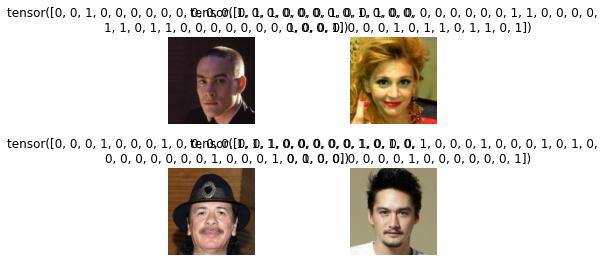

In [ ]:
# Get a batch
dataiter = iter(trainloader)
images, labels = next(dataiter)


# Show results on a 2x2 grid
S=2
for i in range(S):
  for j in range(S):
    X = images[i*S+j]
    label = labels[i*S+j]
    X = np.transpose((X.numpy()/2+0.5), (1, 2, 0))

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(label)
    plt.subplots_adjust(hspace = 0.5)

## 3 Models

### Generator Class
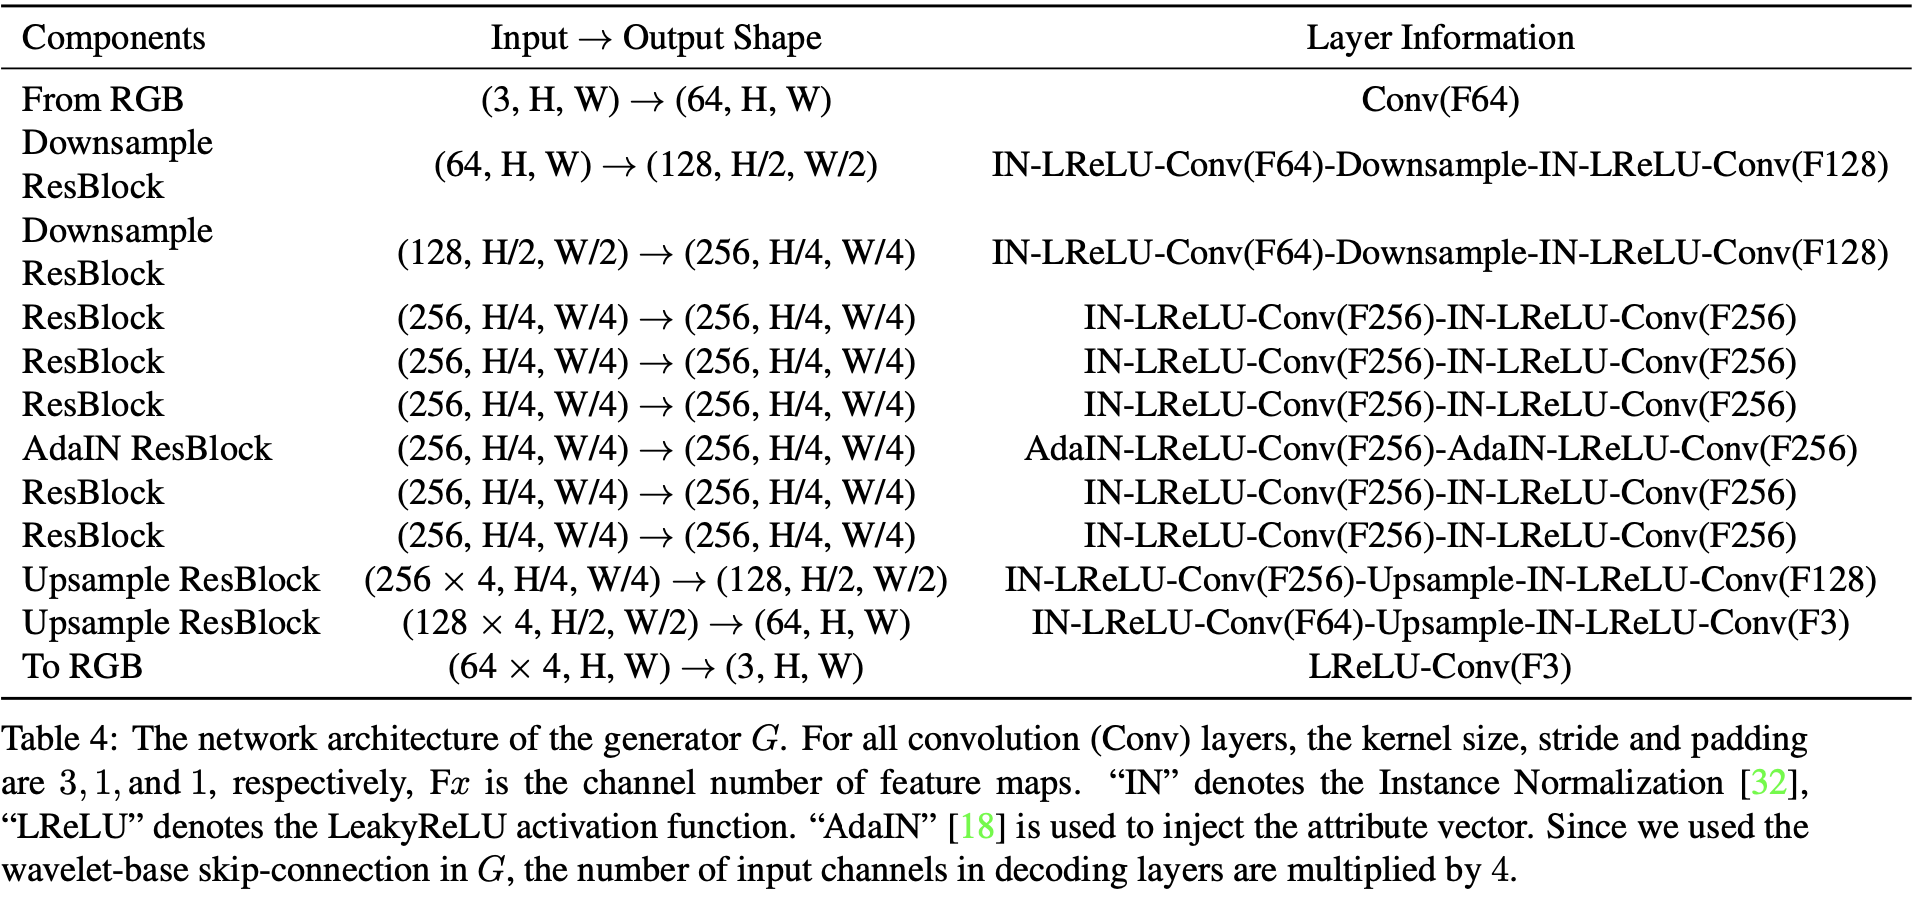


#### Encoder Module

In [ ]:
class Encoder(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self):
        super(Encoder, self).__init__()
        self.Conv = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False);

        self.Downsample1 = nn.Sequential(
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(2),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.Downsample2 = nn.Sequential(
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.MaxPool2d(2),
            nn.InstanceNorm2d(128, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False))

        self.ResidualBlock1 = nn.Sequential(
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.ResidualBlock2 = nn.Sequential(
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.ResidualBlock3 = nn.Sequential(
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))

    def forward(self, x):

        x = self.Conv(x);
        x = self.Downsample1(x);
        x = self.Downsample2(x);
        WL_first = x;
        x = self.ResidualBlock1(x);
        WL_second = x;
        x = self.ResidualBlock2(x);
        WL_third = x;
        x = self.ResidualBlock3(x);

        return x, WL_first, WL_second, WL_third

#### BottleNeck Module

##### AdaIN Style Description


In [ ]:
class AdaIN(nn.Module):
	def __init__(self):
		super().__init__()

	def forward(self, x, y):
		eps = 1e-5	
		y = y.type(torch.float32)
		
		mean_x = torch.mean(x)
		mean_y = torch.mean(y)

		std_x = torch.std(x)
		std_y = torch.std(y)

		mean_x = mean_x.unsqueeze(-1).unsqueeze(-1)
		mean_y = mean_y.unsqueeze(-1).unsqueeze(-1)

		std_x = std_x.unsqueeze(-1).unsqueeze(-1) + eps
		std_y = std_y.unsqueeze(-1).unsqueeze(-1) + eps

		out = (x - mean_x)/ std_x * std_y + mean_y


		return out

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self):
        super(BottleNeck, self).__init__()

        self.AdaIn1 = AdaIN();
        self.AdaINBlock1 = nn.Sequential(
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.AdaIn2 = AdaIN();
        self.AdaINBlock2 = nn.Sequential(
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
        

    def forward(self, x, attributeVector):
        out = self.AdaIn1(x, attributeVector)
        out = self.AdaINBlock1(out)
        out = self.AdaIn2(out, attributeVector)
        out = self.AdaINBlock2(out)
        out += x
        return out

#### Decoder Module

In [ ]:
class Decoder(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self):
        super(Decoder, self).__init__()

        self.ResidualBlock1 = nn.Sequential(
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.ResidualBlock2 = nn.Sequential(
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(256, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False))

        self.Upsample1 = nn.Sequential(
            nn.InstanceNorm2d(256 * 4, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256 * 4, 256 * 4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Upsample(2, mode='nearest'),
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256 * 4, 128, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.Upsample2 = nn.Sequential(
            nn.InstanceNorm2d(128 * 4, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128*4, 128*4, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Upsample(2, mode='nearest'),
            nn.InstanceNorm2d(128*4, affine=True, track_running_stats=True),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128*4, 64, kernel_size=3, stride=1, padding=1, bias=False))
        
        self.Conv = nn.Sequential(
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64 * 4, 3, kernel_size=3, stride=1, padding=1, bias=False)
        )

    def forward(self, x, skipVector):

        x = self.ResidualBlock1(x);
        x = self.ResidualBlock2(x);
        #Check shapes
        x = torch.from_numpy(np.concatenate([x.detach().numpy(), skipVector[0][0], skipVector[0][1], skipVector[0][2]], axis=1))
        x = self.Upsample1(x);
        x = torch.from_numpy(np.concatenate([x.detach().numpy(), skipVector[1][0], skipVector[1][1], skipVector[1][2]], axis=1))
        x = self.Upsample2(x);
        x = torch.from_numpy(np.concatenate([x.detach().numpy(), skipVector[2][0], skipVector[2][1], skipVector[2][2]], axis=1))
        x = self.Conv(x);

        return x

#### Wavelet-Based Skip-Connection

In [ ]:
def WaveLetBasedSkipConnection(inp):
    inp = inp.detach().numpy()
    coeffs2 = pywt.dwt2(inp, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return torch.from_numpy(np.concatenate([torch.from_numpy(LH[:,:,0]), torch.from_numpy(HL[:,:,0]), torch.from_numpy(HH[:,:,0])], axis=1))

#### Putting alltogether for Generator class

In [ ]:
class Generator(nn.Module):
    """Generator network."""
    def __init__(self):
        super(Generator, self).__init__()

        self.Encoder = Encoder()
        self.BottleNeck = BottleNeck()
        self.Decoder = Decoder()

    def forward(self, x, attribVector):
        x, WL_first, WL_second, WL_third = self.Encoder(x)
        x = self.BottleNeck(x, attribVector)
        WL_first = WaveLetBasedSkipConnection(WL_first)
        WL_second = WaveLetBasedSkipConnection(WL_second)
        WL_third = WaveLetBasedSkipConnection(WL_third)
        x = self.Decoder(x, (WL_third, WL_second, WL_first))
        return X


#### Trying to train the Generator Module

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

rand_idx = torch.randperm(labels.size(0))
target_label = labels[rand_idx]
c_org = labels.clone()
c_trg = target_label.clone()

x_real = images.to(device)
c_org = c_org.to(device)             # Original domain labels.
c_trg = c_trg.to(device)             # Target domain labels.
label_org = labels.to(device)        # Labels for computing classification loss.
label_trg = target_label.to(device)  # Labels for computing classification loss.

model = Generator()
if torch.cuda.is_available():
    model.cuda()

In [ ]:
x_fake = model(x_real, c_trg)

plt.imshow(x_fake)
plt.axis('off')
plt.title('label')

### Resnet 18 For Classification

The last two layers of Resnet has 1000 output features. So reducing the number of out features to 40 as in the dataset, we added 2 fully connected layers and in order to achieve non-linearity we have used Leaky ReLu, since it is the general trend of the paper.

In [ ]:
modelResnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

class ClassificationModule(nn.Module):
    def __init__(self):
        super(ClassificationModule, self).__init__()

        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, 40)

        self.main = nn.Sequential(
            modelResnet18,
            nn.Linear(1000, 512, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Linear(512, 40, bias=False)
        )
    
    def forward(self, x):
        return self.main(x)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### High Frequency Discriminator

In [ ]:
class HighFrequencyDiscriminator(nn.Module):
    """High Frequency Discriminator class."""
    def __init__(self):
        super(HighFrequencyDiscriminator, self).__init__()

        self.H0 = nn.Sequential(
            nn.Conv2d(3*3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False)
            )
        
        self.H1 = nn.Sequential(
            nn.Conv2d(3*3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False)
            )

    def forward(self, x, isReal=True):
        if(isReal):
          X = self.H0(x)
        else:
          X = self.H1(x)
        return X

### Image-Level Discriminator

In [ ]:
class ImageLevelDiscriminator(nn.Module):
    """Image Level Discriminator class."""
    def __init__(self):
        super(ImageLevelDiscriminator, self).__init__()

        self.I0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False)
            )
        
        self.I1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False)
            )

    def forward(self, x, isReal = True):
        if(isReal):
          X = self.I0(x)
        else:
          X = self.I1(x)
        return X

### Hyperparameters

In [ ]:
g_lr = (0.0005)
dI_lr = (0.002)
dH_lr = (0.002)

GAN_I_L_weight = 1.0
GAN_H_L_weight = 1.0
AR_L_weight = 1.0
AC_L_weight = 1.0
CYC_L_weight = 10.0

beta1 = 0.0
beta2 = 0.999

alpha = 1

epoch = 200

decay_rate = 0.999

In [ ]:
def reverseAttribVector(a):
  for i in a:
    a = 1 if a==0 else 1
  return a

### Novel Loss Functions Proposed

In [ ]:
def ImageLevelAdversarialLoss(fake, truth):
  loss = torch.log(truth) + torch.log(1 - fake)
  return loss

def HighFreqLoss(fake, truth):
  loss = torch.log(truth) + torch.log(1 - fake)
  return loss

def CycleReqLoss(real, req):
  loss = torch.abs(real - req)
  return loss

def AttribClassLoss(target, output):
  loss = 0
  for i in range(len(target)):
    loss += (target[i] != output[i]) * (target[i] * np.log(output[i]) + (1 - target[i]) * np.log(1 - output[i]))
    
  return loss

def np(input, img0, img1, alpha):
  loss = np.linalg.norm(input-img1) - np.linalg.norm(img1-img0) - (alpha - 1)
  return loss

def HifaFaceLoss(AR, AC, GAN_I, GAN_H, CYC):
  return AR*AR_L_weight + AC*AC_L_weight + GAN_I*GAN_I_L_weight + GAN_H*GAN_H_L_weight + CYC*CYC_L_weight

## HifaFace Model

Putting all above models all together.

In [ ]:
class HifaFace():
    """HifaFace class."""
    def __init__(self):
      self.GeneratorModule = Generator()
      self.ImageLevel = ImageLevelDiscriminator()
      self.HighFrequency = HighFrequencyDiscriminator()
      self.Classification = ClassificationModule()

    def BuildModel(self):
      self.generator_optimizer = torch.optim.Adam(self.GeneratorModule.parameters(), g_lr, [beta1, beta2])
      self.ImageLevel_optimizer = torch.optim.Adam(self.ImageLevel.parameters(), dI_lr, [beta1, beta2])
      self.HighFrequency_optimizer = torch.optim.Adam(self.HighFrequency.parameters(), dH_lr, [beta1, beta2])
      
      self.GeneratorModule.to(device)
      self.ImageLevel.to(device)
      self.HighFrequency.to(device)
      self.Classification.to(device)


    def train(self, training_steps):
      loss_history = []
      for epoch in range(training_steps):
        for i, data in enumerate(trainloader, 0):    
      
          # Our batch:
          inputs, labels = data

          rand_idx = torch.randperm(labels.size(0))
          target_label = labels[rand_idx]
          c_org = labels.clone()
          c_trg = target_label.clone()

          x_real = inputs.to(device)
          c_org = c_org.to(device)             # Original domain labels.
          c_trg = c_trg.to(device)             # Target domain labels.
          label_org = labels.to(device)        # Labels for computing classification loss.
          label_trg = target_label.to(device)  # Labels for computing classification loss.

          self.generator_optimizer.zero_grad()
          # Feed real image for generator
          generated_image = self.GeneratorModule(x_real, c_trg)
          regenerated_real_image = self.GeneratorModule(generated_image, reverseAttribVector(c_trg))

          # Train the ImageLevel discriminator on the input/generated data
          self.ImageLevel_optimizer.zero_grad()
          imLvl_real = self.ImageLevel(x_real, True)
          imLvl_fake = self.ImageLevel(generated_image, False)

          imLvl_discriminator_loss = ImageLevelAdversarialLoss(imLvl_fake, imLvl_real)

          # Train the HighFreq discriminator on the true/generated data
          self.HighFrequency_optimizer.zero_grad()
          HFreq_real_discriminator_out = self.HighFrequencyDiscriminator(c_trg, True)
          HFreq_fake_discriminator_out = self.HighFrequencyDiscriminator(generated_image, False)

          HFreq_discriminator_loss = HighFreqLoss(HFreq_real_discriminator_out, HFreq_fake_discriminator_out)

          # Train the generator
          generator_loss = CycleReqLoss(x_real, regenerated_real_image)
          generator_loss.backward()
          self.generator_optimizer.step()

          imLvl_discriminator_loss.backward()
          self.ImageLevel_optimizer.step()

          HFreq_discriminator_loss.backward()
          self.HighFrequency_optimizer.step()

          real_class = self.Classification(x_real)
          re_generated_class = self.Classification(regenerated_real_image)

          classLoss = AttribClassLoss(real_class, re_generated_class)

          # Attribute Regression loss is not implemented
          #attribRegLoss = AttribRegressionLoss(real_class, re_generated_class)

          loss_history.append(HifaFaceLoss(classLoss, imLvl_discriminator_loss, HFreq_discriminator_loss, generator_loss))
        
        if epoch % 10 == 0: 
          print(f'Epoch {epoch} / {training_steps}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')
          if epoch >= 100:
            GAN_I_L_weight -= decay_rate
            GAN_H_L_weight -= decay_rate
            AR_L_weight -= decay_rate
            AC_L_weight -= decay_rate
            CYC_L_weight -= decay_rate
      
      return loss_history

    def test(self):
      pass



# Run the Module


In [ ]:
Hifa = HifaFace()

Hifa.BuildModel()
Hifa.Train()